In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

plt.rcParams['figure.figsize'] = 5, 10


from functools import partial

def zero_noise(dx):
    return 0

def uniform(a, b, dx):
    return np.random.uniform(a, b, size=dx.shape)

def percent_noise(dx, alpha=2.0):
    return np.random.uniform(-alpha/2*dx, +alpha/2*dx)

def gaussian(dx, mu = 0, var = 1.0):
    return np.random.normal(loc = mu, scale = var)
    

def simulate_input(deltas, noise_fn=zero_noise, prepend_zero=True):
    path = np.zeros(deltas.shape)
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
    
    if prepend_zero:
        return np.concatenate((np.zeros((1,2)), path), axis=0)
    else:
        return path

In [3]:
def sampleAt(x, y, img, radius):        
    return img[x - radius:x + radius, y - radius:y + radius]

def correct(x, y, true, img, sampradius=10, searchradius=50, threshold = 5):
    bestdiff = 1e99
    bestcoords = (x, y)
    
    # increase sampling as radius increases (concentric squares)
    # measure threshold as percentage of pixels (normalize)
    # conversion from floats to integers
    
    for radius in range(searchradius):
        for angle in np.linspace(0, 2 * np.pi, 50):
            xtest = int(x + radius * np.cos(angle / 50 ))
            ytest = int(y + radius * np.sin(angle / 50))
            diff = np.sum(np.square(true - sampleAt(xtest, ytest, img, sampradius)))
            if diff < bestdiff:
                bestdiff = diff
                bestcoords = (xtest, ytest)
            if diff < threshold:
                return (xtest, ytest)
            
    return np.array(bestcoords)

In [5]:
def simulateWithCorrections(deltas, img, noise_fn=zero_noise):
    path = np.zeros(deltas.shape)
    camerapos = np.zeros(deltas.shape)
    
    
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
        camerapos[i] = camerapos[i-1] + deltas[i]
        
        if i % 100 == 0 and i != 0:
            sampradius = 10
            if camerapos[i,0] < sampradius\
            or camerapos[i,1] < sampradius\
            or camerapos[i,0] + sampradius >= img.shape[0]\
            or camerapos[i,1] + sampradius >= img.shape[1]: 
                pass
            else:
                path[i] = correct(path[i,0], path[i,1], sampleAt(int(camerapos[i,0]), int(camerapos[i,1]), img, sampradius), img)
    return path

ValueError: operands could not be broadcast together with shapes (20,20) (20,0) 

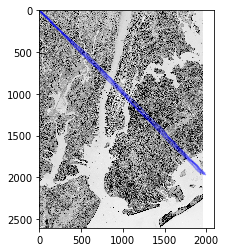

In [14]:
import skimage as ski

img = ski.io.imread('manhattan.jpg', as_gray = True)
fig, ax = plt.subplots()
ax.imshow(img, cmap='Greys')



xdeltas = np.ones(((np.min(img.shape)), 1))
ydeltas = np.ones(((np.min(img.shape), 1)))

deltas = np.hstack((xdeltas, ydeltas))

path = simulate_input(deltas)


simulated_paths = []

ax.plot(path[0,:], path[1,:], linewidth=1, color='red')


for i in range(10):
    simulated = simulate_input(deltas, percent_noise)
    
    corrected = simulateWithCorrections(deltas, img, percent_noise)
    
    ax.plot(simulated[:,0], simulated[:,1], 'b', alpha=0.4)
    ax.plot(corrected[0,:], corrected[1,:], 'g', alpha=0.5)



In [174]:
corrected[0,:]

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.962e+03, 1.963e+03,
       1.964e+03])